In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)


# Create a colormap with a smooth gradient representing the visible spectrum
def create_spectrum_colormap(clim=(350, 780), gamma=0.8):
    norm = plt.Normalize(*clim)
    wl = np.arange(clim[0], clim[1] + 1, 2)
    colorlist = [wavelength_to_rgb(w, gamma) for w in wl]
    spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)
    return spectralmap

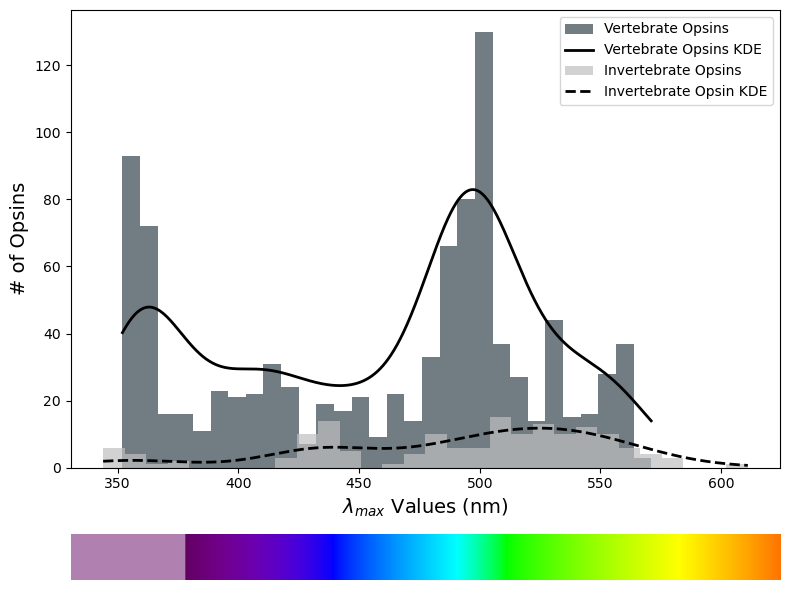

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm
from deepBreaks.preprocessing import read_data

vert_metaDataFileName = "c:/Users/safra/Documents\GitHub/visual-physiology-opsin-db/vpod_data/VPOD_1.1/formatted_database_subsets/vpod_data_subsets_2024-05-02/vert_meta.tsv"
inv_metaDataFileName = "c:/Users/safra/Documents\GitHub/visual-physiology-opsin-db/vpod_data/VPOD_1.1/formatted_database_subsets/vpod_data_subsets_2024-05-02/inv_meta.tsv"

vert_meta_data = read_data(vert_metaDataFileName, seq_type = None, is_main=False)
invert_meta_data = read_data(inv_metaDataFileName, seq_type = None, is_main=False)

# Separate lambda_max values based on metadata
lambda_max_vertebrate = vert_meta_data['Lambda_Max']
lambda_max_invertebrate = invert_meta_data['Lambda_Max']

# Create figure and axes for the histogram
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [10, 1]})
ax_hist = axs[0]

# Histogram without density for vertebrate opsins
n, bins, patches = ax_hist.hist(lambda_max_vertebrate, bins=30, color='#36454f', edgecolor='none', alpha=0.7,
                           label='Vertebrate Opsins')

# Overlay KDE curve scaled by the total number of items for vertebrate opsins
kde_vertebrate = gaussian_kde(lambda_max_vertebrate)
x_vals_vertebrate = np.linspace(min(lambda_max_vertebrate), max(lambda_max_vertebrate), 1000)
y_vals_vertebrate = kde_vertebrate(x_vals_vertebrate) * 10 * len(lambda_max_vertebrate)
ax_hist.plot(x_vals_vertebrate, y_vals_vertebrate, color='black', linewidth=2,
        label='Vertebrate Opsins KDE')

# Create a second histogram for invertebrate opsins
n, bins, patches = ax_hist.hist(lambda_max_invertebrate, bins=30, color='#C0C0C0', edgecolor='none', alpha=0.7,
                           label='Invertebrate Opsins')

# Overlay KDE curve scaled by the total number of items for invertebrate opsins
kde_invertebrate = gaussian_kde(lambda_max_invertebrate)
x_vals_invertebrate = np.linspace(min(lambda_max_invertebrate), max(lambda_max_invertebrate), 1000)
y_vals_invertebrate = kde_invertebrate(x_vals_invertebrate) * 10 * len(lambda_max_invertebrate)
ax_hist.plot(x_vals_invertebrate, y_vals_invertebrate, color='black', linewidth=2, ls = '--',
        label='Invertebrate Opsin KDE')

# Customize plot
ax_hist.set_xlabel('$\lambda_{max}$ Values (nm)', fontsize=14)
ax_hist.set_ylabel('# of Opsins', fontsize=14)
ax_hist.legend()


# Color bar subplot
ax_colorbar = axs[1]

# Wavelength range for the visible spectrum in nanometers
#wavelengths_colorbar = np.linspace(300, 620, 1000)

# Wavelength range for the color background in nanometers
wavelengths_background = np.linspace(min(lambda_max_invertebrate-10), max(lambda_max_invertebrate+10), 1000)

background_colors = [wavelength_to_rgb(w) for w in wavelengths_background]

# Create a colormap representing the visible spectrum
spectrum_colormap = create_spectrum_colormap()

# Create an image with a single row and a smooth gradient colormap
image = ax_colorbar.imshow([background_colors], cmap=spectrum_colormap, aspect='auto', extent=[300, 620, 0, 1])

# Customize color bar plot
ax_colorbar.set_xlim(300, 620)
ax_colorbar.set_ylim(0, 1)
ax_colorbar.axis('off')

# Add color bar
#cbar = plt.colorbar(image, ax=ax_colorbar, orientation='horizontal', pad=0.04, aspect=50)
#cbar.set_label('Wavelength (nm)', fontsize=12)

# Adjust layout and save the plots
plt.tight_layout()
fileout = 'sep_histograms_with_scaled_kde_and_colorbar.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight', dpi=300)
fileout = 'sep_histograms_with_scaled_kde_and_colorbar.png'
plt.savefig(fileout, format='png', bbox_inches='tight', dpi=300)

plt.show()


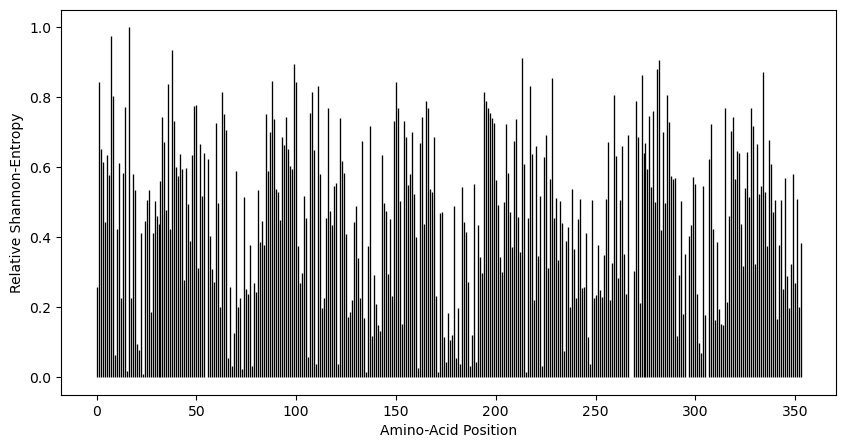

In [2]:
#Creating an entropy plot of our WT dataset alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
import numpy as np
from scipy.stats import entropy
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# Load your MSA (replace 'opsin_msa.fasta' with your file)
alignment = AlignIO.read("./figures/VPOD_1.1/wt_aligned_vpod_1.1_gap_dropped.fasta", "fasta")
summary_align = AlignInfo.SummaryInfo(alignment)
# Get amino acid frequencies at each position
freqs = summary_align.pos_specific_score_matrix(chars_to_ignore=['-', 'X', 'O', 'Z'])


rel_entropies = []
for pos in range(len(alignment[0])):
#for pos in freqs:
    # Extract frequencies for the current position as a list
    pos_freqs = list(freqs[pos].values())

    # Normalize frequencies
    total = sum(pos_freqs)
    pos_freqs = [freq / total for freq in pos_freqs]

    # Calculate entropy for the normalized frequencies
    rel_entropies.append(entropy(pos_freqs))
    
# Normalize relative entropy to 0-1 scale
rel_ent_min = min(rel_entropies)
rel_ent_max = max(rel_entropies)
relative_entropy_norm = [(x - rel_ent_min) / (rel_ent_max - rel_ent_min) for x in rel_entropies]

plt.figure(figsize=(10, 5))
plt.vlines(x=range(len(relative_entropy_norm)), ymin=0, ymax=relative_entropy_norm, color='k', linewidth=0.95, alpha = 1)
plt.xlabel('Amino-Acid Position')
plt.ylabel('Relative Shannon-Entropy')
#plt.title('Relative Entropy')
plt.grid(visible=False)
fileout = 'shannon_ent_plot_wt.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()

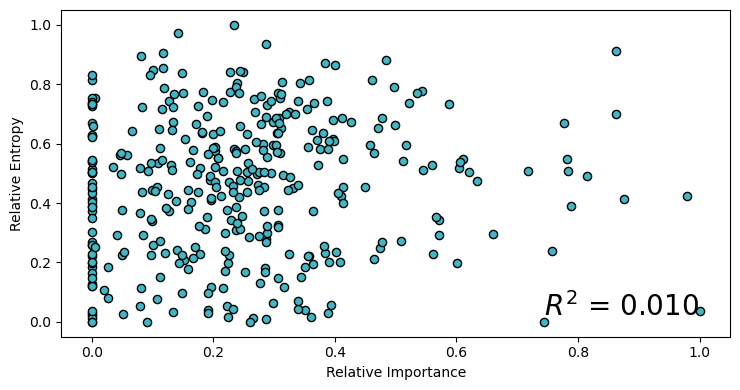

In [4]:
from deepBreaks.preprocessing import read_data
import numpy as np
from scipy import stats

#Checking for correlation between Relative Importance and Relative Entropy Scores
testFileName = f"./figures/VPOD_1.1/vpod_1.1_wt_importance_report.csv"

#meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
base_test = read_data(testFileName, seq_type = None, is_main=False)

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]

plt.xlabel('Relative Importance')
plt.ylabel('Relative Entropy')
plt.scatter((base_test['BayesianRidge'][:354]), relative_entropy_norm, c='#41b6c4', edgecolors='k', s = 35)
plt.annotate(f"$R^2$ = {stats.linregress(base_test['BayesianRidge'][:354], relative_entropy_norm)[2]**2:.3f}", (max(base_test['lgbm']), min(relative_entropy_norm)), ha='right', va='bottom', fontsize=20, c='k')

plt.show()


In [10]:
import re
import joblib
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from deepBreaks.preprocessing import read_data

# Function to get prediction interval for a linear regression
def get_prediction_interval(prediction, y_test, test_predictions, pi=0.95):
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper


In [7]:
report_dir = './figures/VPOD_1.1'
WdstestFileName = f"{report_dir}/wds_itr_test_results.csv"
base_test = read_data(WdstestFileName, seq_type = None, is_main=False)

In [8]:
wt_metadata = f"{report_dir}/wt_meta.tsv"
wt_meta = read_data(wt_metadata, seq_type = None, is_main=False)

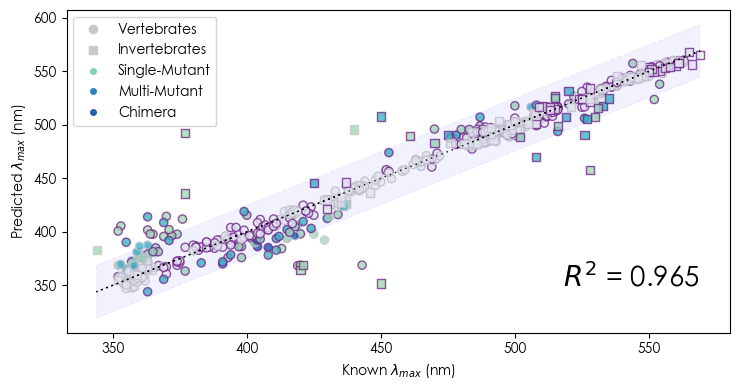

<Figure size 750x400 with 0 Axes>

0.9650983650543372


In [11]:
test = 'wds_vpod_1.1'
mut_type = []
edgecolors = []
colors = []
wt_acc_list = []
wt_lmax = []
mut_diff = []
mut_diff_2 = []
for ind in base_test.index:
    if abs(base_test['Difference'][ind]) >= 10:
        #edgecolors.append('k')
        if '-' in str(base_test['Accession'][ind]):
            #dark blue - chimeras
            colors.append('#225ea8')
            mut_type.append('Chimera')
        elif str(base_test['Mutations'][ind]).count('_') >= 1 or str(base_test['Mutations'][ind]).count(',') >= 1:
            #green-blue - one mutation
            colors.append('#41b6c4')
            mut_type.append('Multiple Mutations')
        elif str(base_test['Mutations'][ind]) != 'nan' and str(base_test['Mutations'][ind]).count('_') == 0 and str(base_test['Mutations'][ind]).count(',') == 0:
            #green-blue - one mutation
            colors.append('#a1dab4')
            mut_type.append('Single Mutation')
        else:
            #light-yellow - Wild-Type
            colors.append('#ffffb2')
            mut_type.append('Wild-Type')
    else:
        colors.append('#f0f0f0')
        #edgecolors.append('#c9c9c9')
        if '-' in str(base_test['Accession'][ind]):
            mut_type.append('Chimera')
        elif str(base_test['Mutations'][ind]).count('_') >= 1 or str(base_test['Mutations'][ind]).count(',') >= 1:
            mut_type.append('Multiple Mutations')
        elif str(base_test['Mutations'][ind]) != 'nan' and str(base_test['Mutations'][ind]).count('_') == 0 and str(base_test['Mutations'][ind]).count(',') == 0:
            mut_type.append('Single Mutation')
        else:
            mut_type.append('Wild-Type')
            
            
    repeat_check = 0
    for wt in wt_meta.index:
        if repeat_check < 1:
            acc = wt_meta['Accession'][wt]
            acc = acc.split('.')[0]
            wt_acc = re.compile(f"^{acc}")

            if wt_acc.match(base_test['Accession'][ind]):
                diff = base_test['Lambda_Max'][ind]-wt_meta['Lambda_Max'][wt]
                if abs(diff) >= 10:
                    edgecolors.append('#762a83')
                else:
                    edgecolors.append('#c9c9c9')
                mut_diff.append(abs(diff))
                mut_diff_2.append(diff)
                wt_acc_list.append(wt_meta['Accession'][wt])
                wt_lmax.append(wt_meta['Lambda_Max'][wt])

                repeat_check += 1
            else:
                pass
        else:
            pass
    if repeat_check == 0:
        edgecolors.append('#c9c9c9')
        mut_diff.append('NA')
        mut_diff_2.append('NA')

        wt_acc_list.append('No Match')
        wt_lmax.append('NA')
    else:
        pass

mut_wt_comp = pd.DataFrame()
mut_wt_comp["Mut_Acc"] = base_test["Accession"]
mut_wt_comp["WT_Acc"] = wt_acc_list
mut_wt_comp["Mut_Lmax"] = base_test["Lambda_Max"]
mut_wt_comp["WT_Lmax"] = wt_lmax
mut_wt_comp['Reg_Diff'] = mut_diff_2
mut_wt_comp["Abs_Diff"] = mut_diff
mut_wt_comp["Edge_Colors"] = edgecolors
mut_wt_comp.to_csv(path_or_buf= f'wt_mut_comp.csv',index_label=True,mode="w")

base_test['mutant_type'] = mut_type
#plotting the predicted vs. known lambda max values...

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Vertebrate Opsin Dataset")

# Create a new column 'Marker' based on 'Phylum'
true_lmax = base_test['Lambda_Max']
predictions = base_test['Prediction']
base_test['Marker'] = np.where(base_test['Phylum'] == 'Chordata', 'o', 's')
markers = base_test['Marker'].tolist()
mask_o = np.array(markers) == 'o'
mask_s = np.array(markers) == 's'
# Create two separate scatter plots for invertebrates and vertebrates
scatter1 = plt.scatter(true_lmax[mask_o], predictions[mask_o], c=np.array(colors)[mask_o], ec=np.array(edgecolors)[mask_o], edgecolors='k', s=35, alpha=0.8, marker='o', label='Vertebrates')
scatter2 = plt.scatter(true_lmax[mask_s], predictions[mask_s], c=np.array(colors)[mask_s], ec=np.array(edgecolors)[mask_s], edgecolors='k', s=35, alpha=0.8, marker='s', label='Invertebrates')


#plt.scatter(base_test['Lambda_Max'], base_test['Prediction'], c=colors, ec = edgecolors, edgecolors='k', s = 35)
plt.plot(base_test['Lambda_Max'], base_test['Lambda_Max'], c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))

# Confidence ribbon using prediction interval
# Sort data by 'Lambda_Max' for smoother ribbon
sorted_indices = np.argsort(base_test['Lambda_Max'])
sorted_lambda_max = base_test['Lambda_Max'].values[sorted_indices]
sorted_prediction = base_test['Prediction'].values[sorted_indices]
lower_vet = []
upper_vet = []
for i in sorted_lambda_max:
    lower, prediction, upper = get_prediction_interval(i, base_test['Lambda_Max'], base_test['Prediction'])
    lower_vet.append(lower)
    upper_vet.append(upper)

# Plotting the confidence ribbon directly using fill_between
plt.fill_between(sorted_lambda_max, lower_vet, upper_vet, color='blue', alpha=0.05, ls = '--')


plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c9c9c9', markeredgecolor= '#c9c9c9', markersize=6),
                  plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#c9c9c9', markeredgecolor= '#c9c9c9', markersize=6),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#7fcdbb', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#2c7fb8', markersize=12),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#225ea8', markersize=12)]
legend_labels = ['Vertebrates', 'Invertebrates','Single-Mutant', 'Multi-Mutant', 'Chimera']

# Adjust bbox_to_anchor values to place the legend inside the graph
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

#plot and adjust position of the R^2 value
plt.annotate(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]**2:.3f}", (max(base_test['Lambda_Max']), min(base_test['Prediction'])), ha='right', va='bottom', fontsize=20, c='k')

#plt.xticks(range(min(umd), max(umd)+1))
fileout = f'{test}_iter_test_95ci.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = f'{test}_iter_test_95ci.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

base_test['Colors'] = colors
base_test['EdgeColors'] = edgecolors
base_test = base_test[['Species', 'Phylum', 'Opsin_Family', 'Accession', 'Mutations','Lambda_Max','Prediction','Difference','Colors','EdgeColors','mutant_type']]
#writing df to a csv file for secondary analysis in report directory
base_test.to_csv(path_or_buf= f'{test}_itr_test_results.csv',index = 'Feature',mode="w")

#calculating r^2, mae, mape, sqe, and rsque for the model on our subsample of extracted test data
model_testing__report = f'{report_dir}/model_testing report.tsv'
base_rsq = stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]**2
print(base_rsq)
base_mae = mean_absolute_error(base_test['Lambda_Max'],base_test['Prediction'])
#print(base_mae)
base_mape = mean_absolute_percentage_error(base_test['Lambda_Max'],base_test['Prediction'])
#print(base_mape)
base_sqe = mean_squared_error(base_test['Lambda_Max'],base_test['Prediction'])
#print(base_sqe)
base_rsqe = mean_squared_error(base_test['Lambda_Max'],base_test['Prediction'],squared = False)
#print(base_rsqe)
with open(model_testing__report , 'a') as f:
    f.write(f'Base Model R^2\tMAE\tMAPE\tSQE\tRSQE\n')
    f.write(f'{str(base_rsq)}\t{str(base_mae)}\t{str(base_mape)}\t{str(base_sqe)}\t{str(base_rsqe)}')

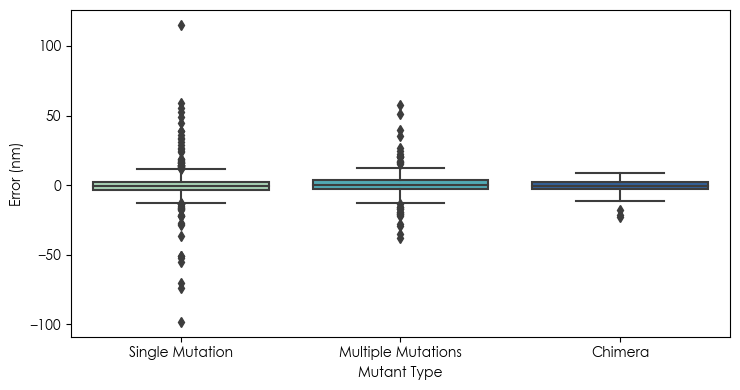

<Figure size 750x400 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['#a1dab4','#41b6c4','#225ea8']

#sns.boxplot(x='mutant_type', y='Difference', data=base_test, dodge=False, palette=palette, order = ['Wild-Type', 'Single Mutation', 'Multiple Mutations', 'Chimera'])
sns.boxplot(x='mutant_type', y='Difference', data=base_test, dodge=False, palette=palette, order = ['Single Mutation', 'Multiple Mutations', 'Chimera'])

# Customize axis labels
plt.xlabel('Mutant Type')
plt.ylabel('Error (nm)')

#save file
fileout = 'wds_iter_test_err_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'wds_iter_test_err_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


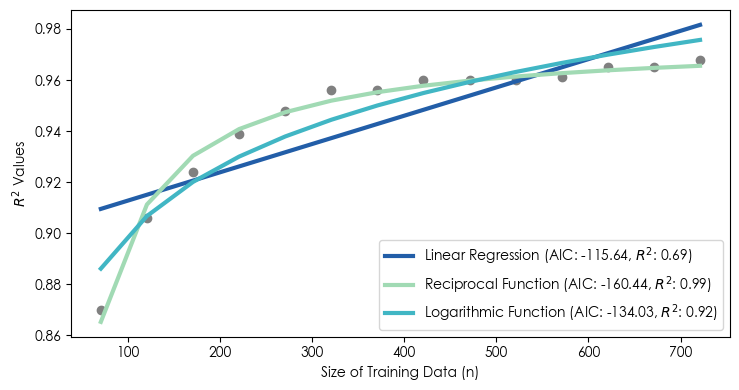

<Figure size 750x400 with 0 Axes>

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
# Data from Rivers and Morin, in units of mm
x = np.array([721, 671, 621, 571, 521, 471, 421, 371, 321, 271, 221, 171, 121, 71])  # Number of data points
y = np.array([0.968, 0.965, 0.965, 0.961, 0.960, 0.960, 0.960, 0.956, 0.956, 0.948, 0.939, 0.924, 0.906, 0.870])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))


# Plot data and fitted models
plt.scatter(x, y, c = 'gray')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, $R^2$: {r2_linear:.2f})', c = '#225ea8', linewidth = 3)
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, $R^2$: {r2_reciprocal:.2f})', c = '#a1dab4', linewidth = 3)
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, $R^2$: {r2_logarithmic:.2f})', c = '#41b6c4', linewidth = 3)
plt.xlabel('Size of Training Data (n)')
plt.ylabel('$R^2$ Values')
plt.legend()
#plt.title('Training Data Size vs. Performance: Vertebrate Models')
#save file
fileout = 'vert_perf_vs_seq_plts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'vert_perf_vs_seq_plts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


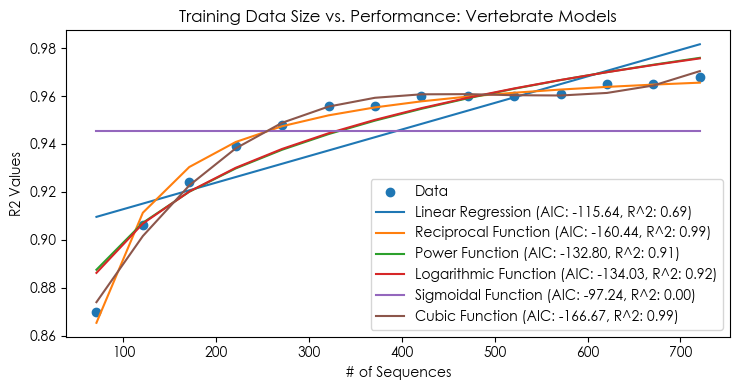

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
# Data from Rivers and Morin, in units of mm
x = np.array([721, 671, 621, 571, 521, 471, 421, 371, 321, 271, 221, 171, 121, 71])  # Number of data points
y = np.array([0.968, 0.965, 0.965, 0.961, 0.960, 0.960, 0.960, 0.956, 0.956, 0.948, 0.939, 0.924, 0.906, 0.870])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: Vertebrate Models')
plt.show()


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
# Data from Rivers and Morin, in units of mm
x = np.array([721, 671, 621, 571, 521, 471, 421, 371, 321, 271, 221, 171, 121, 71])  # Number of data points
y = np.array([0.968, 0.965, 0.965, 0.961, 0.960, 0.960, 0.960, 0.956, 0.956, 0.948, 0.939, 0.924, 0.906, 0.870])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.9017 + 0.0001 * x
Reciprocal: y = -7.8952 / x + 0.9765
Power: y = 0.7452 * x^0.0410
Logarithmic: y = 0.0386 * log(x) + 0.7215
Sigmoidal: y = -103.3921 / (1 + e^(-1.0000 * (x - 1.0000))) + 104.3377
Cubic: y = 0.0000 * x^3 + -0.0000 * x^2 + 0.0008 * x + 0.8219
Exponential Decay with Offset: y = 1.0000 * e^(-1.0000 * x) + 0.9456


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


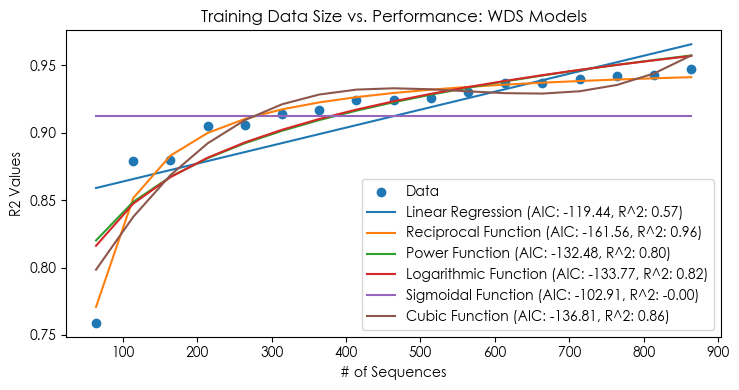

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
x = np.array([864,814,764,714,664,614,564,514,464,414,364,314,264,214,164,114,64])  # Number of data points
y = np.array([0.947,0.943,0.942,0.940,0.937,0.937,0.930,0.926,0.924,0.924,0.917,0.914,0.906,0.905,0.880,0.879,0.759])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: WDS Models')
plt.show()

In [56]:
# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.8505 + 0.0001 * x
Reciprocal: y = -11.7836 / x + 0.9549
Power: y = 0.6404 * x^0.0595
Logarithmic: y = 0.0541 * log(x) + 0.5911
Sigmoidal: y = -102.4809 / (1 + e^(-1.0000 * (x - 1.0000))) + 103.3933
Cubic: y = 0.0000 * x^3 + -0.0000 * x^2 + 0.0011 * x + 0.7347
Exponential Decay with Offset: y = 1.0000 * e^(-1.0000 * x) + 0.9124


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


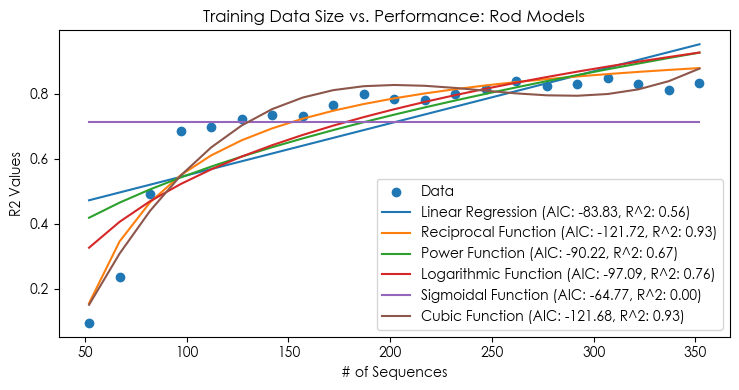

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
x = np.array([352,337,322,307,292,277,262,247,232,217,202,187,172,157,142,127,112,97,82,67,52])  # Number of data points
y = np.array([0.834,0.812223,0.82989,0.848674,0.829916,0.823913,0.837994,0.813817,0.800248,0.780648,0.783326,0.798657,0.765678,0.730895,0.734695,0.721046,0.696243,0.685208,0.490642,0.236599,0.096072])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: Rod Models')
plt.show()

In [62]:
# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.3893 + 0.0016 * x
Reciprocal: y = -44.0622 / x + 1.0035
Power: y = 0.0812 * x^0.4150
Logarithmic: y = 0.3134 * log(x) + -0.9115
Sigmoidal: y = -101.9967 / (1 + e^(-1.0000 * (x - 1.0000))) + 102.7086
Cubic: y = 0.0000 * x^3 + -0.0001 * x^2 + 0.0187 * x + -0.6229
Exponential Decay with Offset: y = 1.0000 * e^(-1.0000 * x) + 0.7119


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


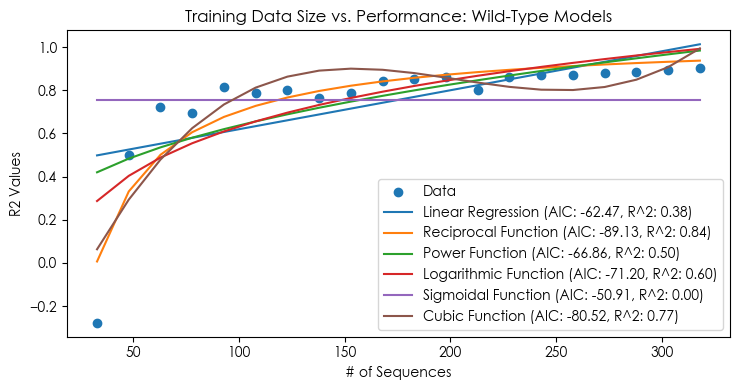

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Given data
# Data from Rivers and Morin, in units of mm
x = np.array([318,303,288,273,258,243,228,213,198,183,168,153,138,123,108,93,78,63,48,33])  # Number of data points
y = np.array([0.902,0.892,0.884,0.878,0.870,0.869,0.863,0.800,0.863,0.853,0.843,0.788,0.765,0.801,0.788,0.817,0.695,0.723,0.499,-0.277])  # R^2 values

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)

# Calculate AIC values
aic_linear = 2 + len(x) * np.log(np.sum((y - y_predicted_linear)**2) / len(x))
aic_reciprocal = 2 + len(x) * np.log(np.sum((y - y_predicted_reciprocal)**2) / len(x))
aic_power = 2 + len(x) * np.log(np.sum((y - y_predicted_power)**2) / len(x))
aic_logarithmic = 2 + len(x) * np.log(np.sum((y - y_predicted_logarithmic)**2) / len(x))
aic_sigmoidal = 4 + len(x) * np.log(np.sum((y - y_predicted_sigmoidal)**2) / len(x))
aic_cubic = 4 + len(x) * np.log(np.sum((y - y_predicted_cubic)**2) / len(x))

# Plot data and fitted models
plt.scatter(x, y, label='Data')
plt.plot(x, y_predicted_linear, label=f'Linear Regression (AIC: {aic_linear:.2f}, R^2: {r2_linear:.2f})')
plt.plot(x, y_predicted_reciprocal, label=f'Reciprocal Function (AIC: {aic_reciprocal:.2f}, R^2: {r2_reciprocal:.2f})')
plt.plot(x, y_predicted_power, label=f'Power Function (AIC: {aic_power:.2f}, R^2: {r2_power:.2f})')
plt.plot(x, y_predicted_logarithmic, label=f'Logarithmic Function (AIC: {aic_logarithmic:.2f}, R^2: {r2_logarithmic:.2f})')
plt.plot(x, y_predicted_sigmoidal, label=f'Sigmoidal Function (AIC: {aic_sigmoidal:.2f}, R^2: {r2_sigmoidal:.2f})')
plt.plot(x, y_predicted_cubic, label=f'Cubic Function (AIC: {aic_cubic:.2f}, R^2: {r2_cubic:.2f})')
plt.xlabel('# of Sequences')
plt.ylabel('R2 Values')
plt.legend()
plt.title('Training Data Size vs. Performance: Wild-Type Models')
plt.show()

In [64]:

# Fit linear regression model
reg_linear = LinearRegression().fit(x.reshape(-1, 1), y)
a_linear = reg_linear.intercept_
b_linear = reg_linear.coef_[0]
y_predicted_linear = a_linear + b_linear * x
r2_linear = r2_score(y, y_predicted_linear)
equation_linear = f'Linear: y = {a_linear:.4f} + {b_linear:.4f} * x'

# Reciprocal function
def reciprocal(x, a, b):
    return a / x + b

# Fit reciprocal model
reciprocal_params, _ = curve_fit(reciprocal, x, y)
a_reciprocal, b_reciprocal = reciprocal_params
y_predicted_reciprocal = reciprocal(x, a_reciprocal, b_reciprocal)
r2_reciprocal = r2_score(y, y_predicted_reciprocal)
equation_reciprocal = f'Reciprocal: y = {a_reciprocal:.4f} / x + {b_reciprocal:.4f}'

# Power function model
def power_function(x, a, b):
    return a * np.power(x, b)

# Fit power function model
power_params, _ = curve_fit(power_function, x, y)
a_power, b_power = power_params
y_predicted_power = power_function(x, a_power, b_power)
r2_power = r2_score(y, y_predicted_power)
equation_power = f'Power: y = {a_power:.4f} * x^{b_power:.4f}'

# Logarithmic function model
def logarithmic_function(x, a, b):
    return a * np.log(x) + b

# Fit logarithmic function model
logarithmic_params, _ = curve_fit(logarithmic_function, x, y)
a_logarithmic, b_logarithmic = logarithmic_params
y_predicted_logarithmic = logarithmic_function(x, a_logarithmic, b_logarithmic)
r2_logarithmic = r2_score(y, y_predicted_logarithmic)
equation_logarithmic = f'Logarithmic: y = {a_logarithmic:.4f} * log(x) + {b_logarithmic:.4f}'

# Sigmoidal function model
def sigmoidal_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

# Fit sigmoidal function model
sigmoidal_params, _ = curve_fit(sigmoidal_function, x, y)
a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal = sigmoidal_params
y_predicted_sigmoidal = sigmoidal_function(x, a_sigmoidal, b_sigmoidal, c_sigmoidal, d_sigmoidal)
r2_sigmoidal = r2_score(y, y_predicted_sigmoidal)
equation_sigmoidal = f'Sigmoidal: y = {a_sigmoidal:.4f} / (1 + e^(-{c_sigmoidal:.4f} * (x - {d_sigmoidal:.4f}))) + {b_sigmoidal:.4f}'

# Cubic function model
def cubic_function(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

# Fit cubic function model
cubic_params, _ = curve_fit(cubic_function, x, y)
a_cubic, b_cubic, c_cubic, d_cubic = cubic_params
y_predicted_cubic = cubic_function(x, a_cubic, b_cubic, c_cubic, d_cubic)
r2_cubic = r2_score(y, y_predicted_cubic)
equation_cubic = f'Cubic: y = {a_cubic:.4f} * x^3 + {b_cubic:.4f} * x^2 + {c_cubic:.4f} * x + {d_cubic:.4f}'

# Exponential decay function model with y-offset
def exponential_decay_with_offset(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit exponential decay function model with y-offset
exp_decay_params, _ = curve_fit(exponential_decay_with_offset, x, y)
a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset = exp_decay_params
y_predicted_exp_decay_with_offset = exponential_decay_with_offset(x, a_exp_decay_with_offset, b_exp_decay_with_offset, c_exp_decay_with_offset)
r2_exp_decay_with_offset = r2_score(y, y_predicted_exp_decay_with_offset)

# Display equations
print("Equations for Best-Fit Lines:")
print(equation_linear)
print(equation_reciprocal)
print(equation_power)
print(equation_logarithmic)
print(equation_sigmoidal)
print(equation_cubic)


Equations for Best-Fit Lines:
Linear: y = 0.4388 + 0.0018 * x
Reciprocal: y = -34.2551 / x + 1.0450
Power: y = 0.1129 * x^0.3757
Logarithmic: y = 0.3112 * log(x) + -0.8009
Sigmoidal: y = 102.8512 / (1 + e^(-1.0000 * (x - 1.0000))) + -102.0954
Cubic: y = 0.0000 * x^3 + -0.0001 * x^2 + 0.0247 * x + -0.6200


c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\safra\anaconda3\envs\deepBreaks\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
#for adding the opsin family meta-data to the opsin trees made for phylogenetic imputation...
import pandas as pd
def find_replace_and_save(file_path, search_list, replace_list, output_file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Perform iterative find and replace
    for search_term, replace_term in zip(search_list, replace_list):
        search_term = search_term + ':'
        replace_term = search_term[:-1] + '_' + replace_term + ':'
        content = content.replace(search_term, replace_term)

    # Write the modified content to a new file
    with open(output_file_path, 'w') as output_file:
        output_file.write(content)

# Example usage:
input_file_path = 'nmoc_tree.tre'
output_file_path = 'nmoc_tree_ogf.tre'

# Define matches and replacements
wt_metadata = "nmoc_meta.tsv"
wt_meta = pd.read_csv(wt_metadata, sep="\t", index_col = 0)

search_list = list(wt_meta.index.values)
print(search_list)
replace_list = list(wt_meta['Opsin_Family'])
print(replace_list)

find_replace_and_save(input_file_path, search_list, replace_list, output_file_path)



In [11]:
from scipy import stats
import re
import joblib
import numpy as np
from scipy import stats
from scipy.stats import chi2
from scipy.stats import t
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from deepBreaks.preprocessing import read_data

# Function to get prediction interval for a linear regression
def get_prediction_interval(prediction, y_test, test_predictions, pi=0.95):
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper


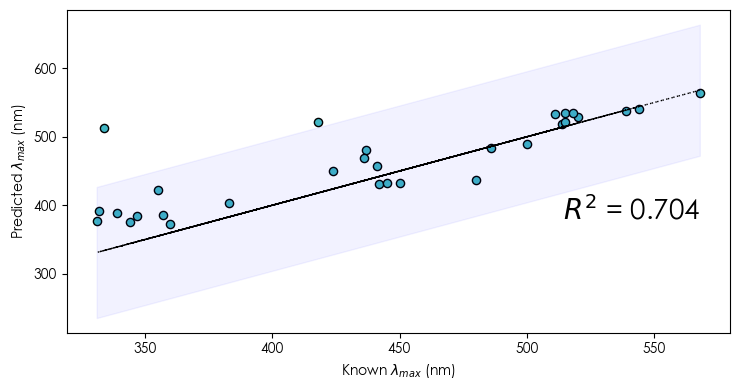

<Figure size 750x400 with 0 Axes>

In [48]:
directory = 'c:/Users/safra/Documents/GitHub/visual-physiology-opsin-db/result_files/msp_tests'
#metaDataFileName = "c:/Users/safra/Documents/GitHub/visual-physiology-opsin-db/vpod_data/VPOD_1.0/formatted_data_splits/vpod_2023-10-16_12-13-11/vert_meta.tsv"
testFileName = f"{directory}/wds_msp_test_results.csv"

#meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
base_test = read_data(testFileName, seq_type = None, is_main=False)

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Vertebrate Opsin Dataset")
plt.scatter(base_test['Lambda_Max'], base_test['Predicted'], c='#41b6c4', edgecolors='k', s = 35)
plt.plot(base_test['Lambda_Max'], base_test['Lambda_Max'], c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))

# Confidence ribbon using prediction interval
# Sort data by 'Lambda_Max' for smoother ribbon
sorted_indices = np.argsort(base_test['Lambda_Max'])
sorted_lambda_max = base_test['Lambda_Max'].values[sorted_indices]
sorted_prediction = base_test['Predicted'].values[sorted_indices]
lower_vet = []
upper_vet = []
for i in sorted_lambda_max:
    lower, prediction, upper = get_prediction_interval(i, base_test['Lambda_Max'], base_test['Predicted'])
    lower_vet.append(lower)
    upper_vet.append(upper)

# Plotting the confidence ribbon directly using fill_between
plt.fill_between(sorted_lambda_max, lower_vet, upper_vet, color='blue', alpha=0.05, ls = '-')


plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

#plot and adjust position of the R^2 value
plt.annotate(f"$R^2$ = {stats.linregress(x = base_test['Lambda_Max'],y = base_test['Predicted'])[2]**2:.3f}", (max(base_test['Lambda_Max']), min(base_test['Predicted'])), ha='right', va='bottom', fontsize=20, c='k')
#plt.annotate(f"$R^2$ = {r2_score(base_test['Lambda_Max'],base_test['Predicted']):1}", (max(base_test['Lambda_Max']), min(base_test['Predicted'])), ha='right', va='bottom', fontsize=20, c='k')

fileout = 'wds_msp_test.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'wds_msp_test.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()

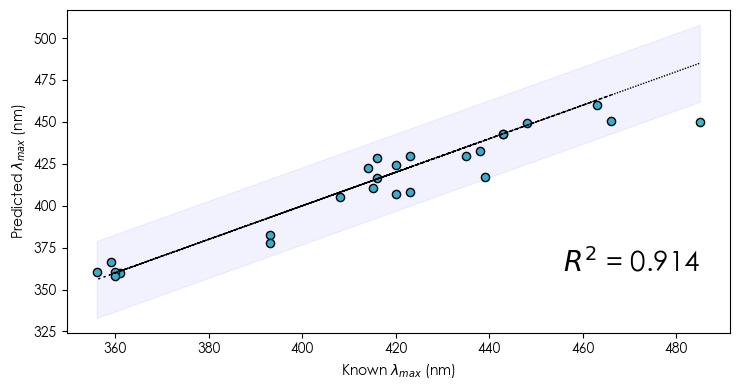

<Figure size 750x400 with 0 Axes>

In [40]:
directory = 'c:/Users/safra/Documents/GitHub/visual-physiology-opsin-db/result_files/sws_ops_prediction_comparison_test'
#metaDataFileName = "c:/Users/safra/Documents/GitHub/visual-physiology-opsin-db/vpod_data/VPOD_1.0/formatted_data_splits/vpod_2023-10-16_12-13-11/vert_meta.tsv"
testFileName = f"{directory}/vert_sws_test_results.csv"

#meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
base_test = read_data(testFileName, seq_type = None, is_main=False)

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'

plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Vertebrate Opsin Dataset")
plt.scatter(base_test['Lambda_Max'], base_test['Prediction'], c='#41b6c4', edgecolors='k', s = 35)
plt.plot(base_test['Lambda_Max'], base_test['Lambda_Max'], c = 'k', linewidth = '1.0', ls = '--', dashes = (1,3))

# Confidence ribbon using prediction interval
# Sort data by 'Lambda_Max' for smoother ribbon
sorted_indices = np.argsort(base_test['Lambda_Max'])
sorted_lambda_max = base_test['Lambda_Max'].values[sorted_indices]
sorted_prediction = base_test['Prediction'].values[sorted_indices]
lower_vet = []
upper_vet = []
for i in sorted_lambda_max:
    lower, prediction, upper = get_prediction_interval(i, base_test['Lambda_Max'], base_test['Prediction'])
    lower_vet.append(lower)
    upper_vet.append(upper)

# Plotting the confidence ribbon directly using fill_between
plt.fill_between(sorted_lambda_max, lower_vet, upper_vet, color='blue', alpha=0.05, ls = '-')


plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')

#plot and adjust position of the R^2 value
#plt.annotate(f"$R^2$ = {r2_score(base_test['Lambda_Max'],base_test['Prediction']):1}", (max(base_test['Lambda_Max']), min(base_test['Prediction'])), ha='right', va='bottom', fontsize=20, c='k')
plt.annotate(f"$R^2$ = {stats.linregress(base_test['Lambda_Max'],base_test['Prediction'])[2]**2:.3f}", (max(base_test['Lambda_Max']), min(base_test['Prediction'])), ha='right', va='bottom', fontsize=20, c='k')

fileout = 'vert_unseen_uss_test.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'vert_unseen_uss_test.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()